In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
df_train = pd.read_csv('data/mnist_train.csv')
df_test = pd.read_csv('data/mnist_test.csv')

In [7]:
print(df_train.shape)
#print(df_test.shape)

(60000, 785)


In [8]:
# df_test.head()

In [9]:
df_features = df_train.iloc[:, 1:785]
df_label = df_train.iloc[:, 0]

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(df_features, df_label, 
                                                      test_size = 0.2,
                                                      random_state = 1234)

In [11]:
print(X_train.shape, X_valid.shape)

(48000, 784) (12000, 784)


In [12]:
X_train = np.array(X_train).reshape(48000, 784)
X_valid = np.array(X_valid).reshape(12000, 784)

In [13]:
X_train = X_train.reshape(48000, 1, 28, 28)
X_train  = torch.from_numpy(X_train).float()

y_train = torch.from_numpy(np.array(y_train))

In [14]:
print(X_train.shape, y_train.shape)

torch.Size([48000, 1, 28, 28]) torch.Size([48000])


In [15]:
X_valid = X_valid.reshape(12000, 1, 28, 28)
X_valid = torch.from_numpy(X_valid).float()

y_valid = torch.from_numpy(np.array(y_valid))

In [16]:
print(X_valid.shape, y_valid.shape)

torch.Size([12000, 1, 28, 28]) torch.Size([12000])


In [17]:
batch_size = 100

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(X_train,y_train)
valid = torch.utils.data.TensorDataset(X_valid,y_valid)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
valid_loader = torch.utils.data.DataLoader(valid, batch_size = batch_size, shuffle = False)

In [18]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
     
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected 1
        self.fc1 = nn.Linear(32 * 5 * 5, 10) 
    
    def forward(self, x):
        # Set 1
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        
        # Set 2
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        
        #Flatten
        out = out.view(out.size(0), -1)

        #Dense
        out = self.fc1(out)
        
        return out

model = CNNModel()

In [19]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
    
model.to(device)

CNNModel(
  (cnn1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=800, out_features=10, bias=True)
)

In [20]:
#Definition of hyperparameters
n_iters = 250
num_epochs = n_iters / (len(X_train) / batch_size)
num_epochs = int(num_epochs)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss().to(device)

# SGD Optimizer
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [21]:
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        #train = Variable(images.view(100,1,28,28))
        #labels = Variable(labels)
        train = images.to(device)
        labels = labels.to(device)
        
        # Clear gradients
        optimizer.zero_grad()
        # Forward propagation
        outputs = model(train)
        # Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        # Calculating gradients
        loss.backward()
        # Update parameters
        optimizer.step()
        
        count += 1
        if count % 10 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in valid_loader:
                
                valid = Variable(images.view(batch_size,1,28,28))
                # Forward propagation
                outputs = model(valid)
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if count % 100 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

Iteration: 10  Loss: 5.363000869750977  Accuracy: 46.33333206176758 %
Iteration: 20  Loss: 1.343904733657837  Accuracy: 72.30833435058594 %
Iteration: 30  Loss: 0.8382713794708252  Accuracy: 80.05833435058594 %
Iteration: 40  Loss: 0.7045939564704895  Accuracy: 85.44166564941406 %
Iteration: 50  Loss: 0.483016699552536  Accuracy: 86.90833282470703 %
Iteration: 60  Loss: 0.36561015248298645  Accuracy: 88.85832977294922 %
Iteration: 70  Loss: 0.4232848286628723  Accuracy: 89.2249984741211 %
Iteration: 80  Loss: 0.4933415949344635  Accuracy: 89.63333129882812 %
Iteration: 90  Loss: 0.44810864329338074  Accuracy: 90.91666412353516 %
Iteration: 100  Loss: 0.3838980197906494  Accuracy: 91.75 %
Iteration: 110  Loss: 0.18992942571640015  Accuracy: 92.32499694824219 %
Iteration: 120  Loss: 0.23533588647842407  Accuracy: 92.88333129882812 %
Iteration: 130  Loss: 0.42365169525146484  Accuracy: 92.49166870117188 %
Iteration: 140  Loss: 0.21078795194625854  Accuracy: 92.90833282470703 %
Iteration: 

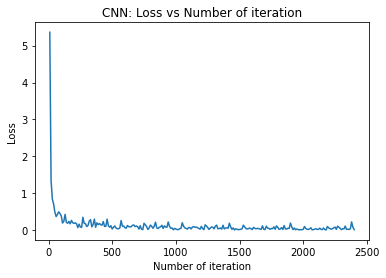

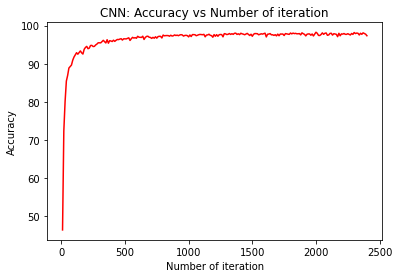

In [22]:
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

In [24]:
print(type(model.state_dict()))

<class 'collections.OrderedDict'>


In [25]:
# Test the model
df_test_features = df_test.iloc[:, 1:785]
df_test_label = df_test.iloc[:, 0]

X_test = df_test_features.to_numpy()
y_test = df_test_label.to_numpy()

In [26]:
sample = 10
img = X_test[sample] #shape (784,1)
img = img.reshape(1, 1, 28, 28) #shape (1,1,28,28)
img  = torch.from_numpy(img).float().to(device) #tensor

prediction = model(img).detach().numpy()[0].argmax()
print('Prediction: ', prediction)

Prediction:  0


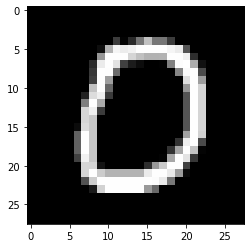

In [27]:
# fig = plt.figure
# plt.imshow(X_test[sample].reshape(28,28), cmap='gray')
# plt.show()

In [28]:
# Save model state
torch.save(model.state_dict(), 'models/mnist_cnn.pt')